 ## General Description
 
 https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc  
In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

File descriptions
train.csv - the training set
test.csv - the test set
sample_submission.csv - A sample submission in the correct format
enbeddings/ - (see below)
Data fields
qid - unique question identifier
question_text - Quora question text
target - a question labeled "insincere" has a value of 1, otherwise 0
This is a Kernels-only competition. The files in this Data section are downloadable for reference in Stage 1. Stage 2 files will only be available in Kernels and not available for download.

What will be available in the 2nd stage of the competition?
In the second stage of the competition, we will re-run your selected Kernels. The following files will be swapped with new data:

test.csv - This will be swapped with the complete public and private test dataset. This file will have ~56k rows in stage 1 and ~376k rows in stage 2. The public leaderboard data remains the same for both versions. The file name will be the same (both test.csv) to ensure that your code will run.
sample_submission.csv - similar to test.csv, this will be changed from ~56k in stage 1 to ~376k rows in stage 2 . The file name will remain the same.
Embeddings
External data sources are not allowed for this competition. We are, though, providing a number of word embeddings along with the dataset that can be used in the models. These are as follows:

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106
wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

In [1]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## Inverted Index 



Inverted indexing 을 하기 위해서는 우선 문서에 포함된 term들을 정제하는 과정이 필요하다. 

이런 과정에서 사용되는 여러가지 방법들(?)이 존재하는데, 그것들에 대한 설명과 

문제점에 대해서 알아보겠다. 





##  Tokenization

Tokenization은 해당 문장에 포함된 단어들을 어떤 기준으로 자를 것인가를 고민하는 문제이다. 

뭐 간단하게 띄어쓰기 기준으로 나누거나 어떤 키워드를 기준으로 나누면 된다고 생각하겠지만 

생각외로 곤란한 부분이 많이 생긴다. 



Finland;s capital : Finland  or Finlands or Finland's 

' 키워드에 대해서 어떻게 나누어야 할 것인가? 

Hewlett-Packard : Hewlett , Pakard or Hewlett and Packard 

두 단어를 따로 볼 것인가 하나로 볼 것인가? 

따로 본다면 San Francisco는? 



이것뿐만 아니다. 기호들은 어떻게 할 것인가에 대한 문제도 있다. 

(800)234-2333 과 같이 전화번호나 3/12/11과 같은 날짜는? 

이런 것들을 모두 고려해서 가장 좋은 성능을 나타내는 Tokenization 방법을 구상해야 할 것이다. 





##  Stop words 

Strop word는 불용어라고 보면 된다. 불용어란 문장에서 내용을 나타내는데 큰 역할을 하지 않은 기능어들을 말한다. 영어권에서 it, am, is ... 이런 것들은 거의 대부분의 문서에서 출현한다. 따라서 이런 기능어들은 사용자가 원하는 문서를 찾아내는데 전혀 도움이 되지 않는다. 따라서 Inverted index를 구성하는 term에서는 대부분 제외된다. 

가장 큰 이유는 문서를 찾는데 도움이 되지 않는데 이것들의 정보를 담기에는 불필요한 메모리 낭비 + 탐색시간 증가떄문이다. 

그러나 여기서도 문제가 생긴다. 대표적인 문제는 이것이다. 

Let it be .. 비틀즈의 유명한 노래제목인데 모두 불용어로 되어있다. 만약 이런 불용어를 다 제거 한다면 평생 찾기 힘들 것이다. 





##  Normalization 

정규화라고도 한다. 하나의 단어가 여러 형태로 표현될때, 하나의 형태로 맞춰주는 것을 말한다. 

U.S.A. 와 USA를 하나로 보거나 SUV, CAR, AUTOMOBIL을 CAR라는 단어와 같이 보는 것을 의미한다. 

이런 정규화를 하기 위해서는 시소러스를 이용하기도 한다. 





##  Stemming

스테밍은 정규화의 한 과정이라고 생각하면 편할것 같다. 예를들면 

automates, automatic, automation 과 같은 단어들을 automat와 같이 하나의 단어로 만드는 것이다. 

스테밍은 언어적인 분석이 아니라 일정 규칙과 패턴으 이용하여 잘라낸다고 생각하면 된다.



##  Lemmaticaion

뭐 스테밍과 같은 의도이긴한데, 이것은 형태소 분석을 이용하여 정확한 원형을 파악하는 것이다. 

am, are, is 같은 것들을 be로 묶어 버린다거나 

cas, cars, car's 같은 것등을 car로 묶는 것이다. 

그러나 영어권에서는 보통 스테밍을 더욱 많이 사용한다. 

그 이유는, 속도와 효율성이 스테밍이 뛰어나기 때문이다. 



출처: https://ra2kstar.tistory.com/55 [초보개발자 이야기.]

In [9]:
train_df = pd.read_csv("../input/Quora/train.csv")
test_df = pd.read_csv("../input/Quora/train.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (1306122, 3)


In [10]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [11]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

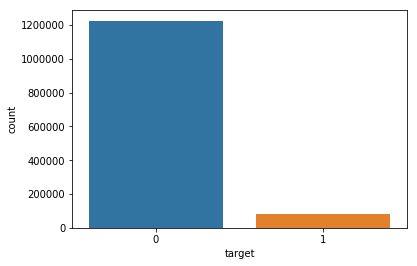

In [12]:
'''
Target Distribution:

First let us look at the distribution of the target variable to understand more about the imbalance and so on.
타겟의 분포가 어떻게 되는지 알아보자 
'''
sns.countplot(train.target)

In [13]:
# Word Frequency plot of sincere & insincere questions:**
'''
각각의 데이터에서 단어의 분포가 어떻게 되는지 
'''
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

    return trace
## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [14]:
#Bigram frequency analysis 
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [15]:
#trigram plots as well 
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [20]:
#Meta Features
## Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

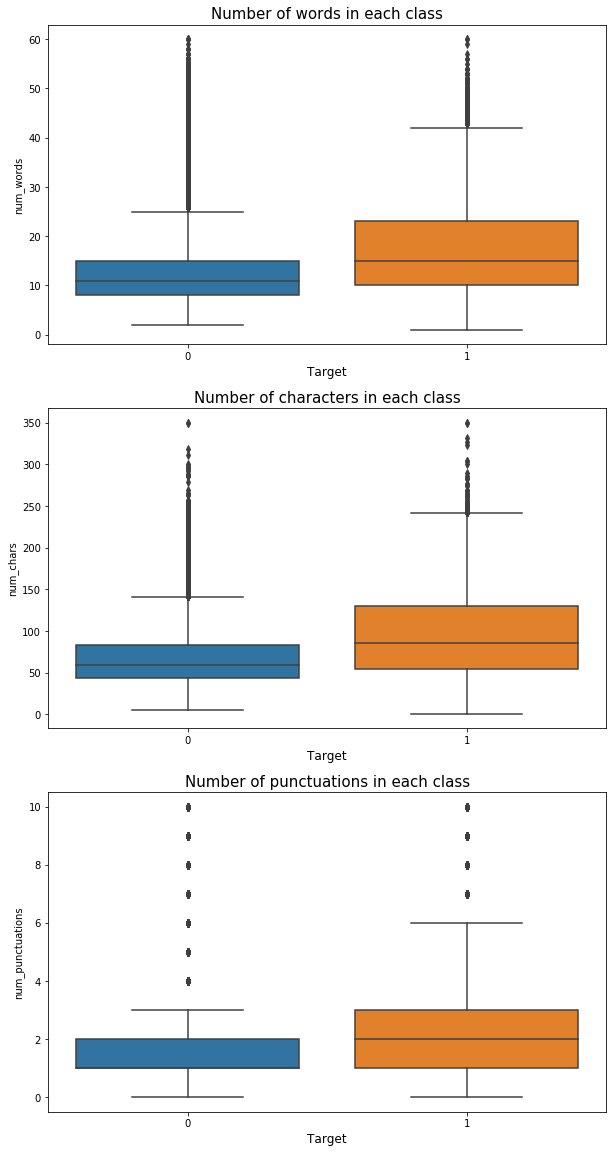

In [21]:
## Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [22]:
'''
insincere question 이 sinsere 보다 더많은 words를 포함하고 있다
이런차이는 model의 feature 에서 유용하다. 

'''


'\ninsincere question 이 sinsere 보다 더많은 words를 포함하고 있다\n이런차이는 model의 feature 에서 유용하다. \n\n'

## Bow (bag of words)  
문서를 숫자 벡터로 변환하는 가장 기본적인 방법은 BOW 이다. BOW방법에서는 전체문서 {d1,d2....dn} 를 구성하는 
고정된 단어장(vocabulary) {t1,t2,....tm} 를 만들고 $d_{i}$ .를 만들어 표시하는 방법이다.  

## Scikit-Learn 의 문서 전처리 기능 


### Scikit-Learn 의 feature_extraction 서브패키지와 feature_extraction.text 서브 패키지는 다음과 같은 문서 전처리용 클래스를 제공한다.

#### DictVectorizer:

각 단어의 수를 세어놓은 사전에서 BOW 벡터를 만든다.
#### CountVectorizer:

문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다.
#### TfidfVectorizer:

CountVectorizer와 비슷하지만 TF-IDF 방식으로 단어의 가중치를 조정한 BOW 벡터를 만든다.
HashingVectorizer:

해시 함수(hash function)을 사용하여 적은 메모리와 빠른 속도로 BOW 벡터를 만든다.

## TF-IDF 
TF-IDF(term frequency - inverse Document Frequency)인코딩은 단어의 갯수 그대로 카운트하지 않고 
모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법이다 

구체적으로 문서 d(document)의 단어 t에 대해서는 다음과 같이 계산한다. 

$$tf-idf(d,t) = tf(d,t) * idf(t)$$

여기서 tf(d,t)는 특정단어의 빈도수 

idf(f): 특정한 단어가 들어있는 문서의 수에 반비례하는 수 
$$idf(d,t) = log\frac{n}{1+df(t)}$$

n - 전체 문서의수 
df(t) 단어 t를 가진 문서의 수  

In [25]:
# Baseline Model:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train_df['question_text'].values.tolist() + test_df['question_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['question_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['question_text'].values.tolist())

In [33]:
train_y = train_df["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [34]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5686239593999021
F1 score at threshold 0.11 is 0.5764561703701991
F1 score at threshold 0.12 is 0.583514983112559
F1 score at threshold 0.13 is 0.5894065912347448
F1 score at threshold 0.14 is 0.592999592999593
F1 score at threshold 0.15 is 0.5958258234725596
F1 score at threshold 0.16 is 0.5966067223292657
F1 score at threshold 0.17 is 0.596876712328767
F1 score at threshold 0.18 is 0.5952500980227413
F1 score at threshold 0.19 is 0.5945033889095434
F1 score at threshold 0.2 is 0.5925169869645096


In [37]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+19.748,castrated
+17.555,muslims
+17.286,democrats
+17.086,liberals
+16.723,castrate
+15.568,indians
+14.499,trump
+14.421,americans
+14.191,women
+14.127,blacks
